In [170]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from Labeling import *
from purged_cv_by_date import *
import lightgbm as lgbm

## Extract Trading Dates and Prices

In [171]:
with open("./Data/stocks.pkl", "rb") as file: 
    stocks = pkl.load(file)

In [172]:
prices = stocks[["PERMNO", "Date", "DlyClose"]]
prices = prices.set_index(["Date", "PERMNO"], drop=True)
prices = prices.loc[~prices.index.duplicated(keep='first'), :]
prices

,,DlyClose
Date,PERMNO,
2013-01-02,10026,64.3200
2013-01-03,10026,64.6800
2013-01-04,10026,64.7700
2013-01-07,10026,63.4007
2013-01-08,10026,63.4300
...,...,...
2023-12-22,93429,175.5300
2023-12-26,93429,173.6900
2023-12-27,93429,175.6100


## Read in Side-labeled Data

In [173]:
with open("./Data/feature_scores_events.pkl", "rb") as file:
    data = pkl.load(file)

In [174]:
data.describe()

,Date,PERMNO,ma_5,ema_5,slope_ma_5,ma_10,ema_10,slope_ma_10,ma_20,ema_20,...,pv_corr,pv_divergence,label,DlyClose,timestamp,End Time,Return,trade_days,Return_dly,Side
count,688224,688224.000000,688224.000000,688224.000000,688224.000000,688224.000000,688224.000000,688224.000000,688224.000000,688224.000000,...,688224.000000,688224.000000,688224.000000,688224.000000,688224,688224,688224.000000,688224.000000,688224.000000,688224.000000
mean,2018-08-07 20:21:03.063188480,66195.741782,0.006251,0.006304,0.007949,0.006261,0.006244,-0.002353,0.006197,0.006096,...,0.003224,-0.003224,0.002897,57.610769,2018-08-07 20:21:03.063188480,2018-08-12 07:04:26.522527744,0.002202,4.059103,0.000593,0.012258
min,2013-04-04 00:00:00,10026.000000,-1.025310,-1.025152,-7.088935,-1.024847,-1.024539,-6.734629,-1.024029,-1.022825,...,-2.491097,-3.332061,-0.950092,0.040600,2013-04-04 00:00:00,2013-04-05 00:00:00,-0.903307,2.000000,-0.400972,-1.000000
25%,2015-11-24 00:00:00,38093.000000,-0.619627,-0.619671,-0.387763,-0.619814,-0.619955,-0.377465,-0.620055,-0.620458,...,-0.754614,-0.732845,-0.022691,13.020000,2015-11-24 00:00:00,2015-12-02 00:00:00,-0.025090,2.000000,-0.007515,-1.000000
50%,2018-08-14 00:00:00,81621.000000,-0.317590,-0.317421,-0.013043,-0.317315,-0.317345,-0.027073,-0.316977,-0.317004,...,-0.026778,0.026778,0.001392,31.920000,2018-08-14 00:00:00,2018-08-17 00:00:00,0.007318,3.000000,0.001453,0.000000
75%,2021-05-11 00:00:00,89708.000000,0.260188,0.260132,0.387345,0.260470,0.260658,0.355186,0.261000,0.260913,...,0.732845,0.754614,0.024631,66.670000,2021-05-11 00:00:00,2021-05-13 00:00:00,0.025641,5.000000,0.007610,1.000000
max,2023-12-01 00:00:00,93429.000000,6.124177,6.118742,6.570649,6.104151,6.095153,6.785469,6.084156,6.061786,...,3.332061,2.491097,208.852217,3696.060000,2023-12-01 00:00:00,2023-12-21 00:00:00,103.187192,16.000000,20.637438,1.000000
std,NaN,30127.982968,1.002969,1.003000,1.089839,1.002969,1.002965,1.028496,1.002867,1.002767,...,1.012377,1.012377,0.319197,110.095093,NaN,NaN,0.169074,2.569951,0.049418,0.804423


In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688224 entries, 0 to 688223
Data columns (total 58 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                688224 non-null  datetime64[ns]
 1   PERMNO              688224 non-null  int64         
 2   ma_5                688224 non-null  float64       
 3   ema_5               688224 non-null  float64       
 4   slope_ma_5          688224 non-null  float64       
 5   ma_10               688224 non-null  float64       
 6   ema_10              688224 non-null  float64       
 7   slope_ma_10         688224 non-null  float64       
 8   ma_20               688224 non-null  float64       
 9   ema_20              688224 non-null  float64       
 10  slope_ma_20         688224 non-null  float64       
 11  ma_60               688224 non-null  float64       
 12  ema_60              688224 non-null  float64       
 13  slope_ma_60         688224 no

In [176]:
data.columns

Index(['Date', 'PERMNO', 'ma_5', 'ema_5', 'slope_ma_5', 'ma_10', 'ema_10',
       'slope_ma_10', 'ma_20', 'ema_20', 'slope_ma_20', 'ma_60', 'ema_60',
       'slope_ma_60', 'ret_1', 'ret_5', 'ret_10', 'ret_20', 'macd_dif',
       'macd_dea', 'macd', 'macd_cross', 'bb_mid', 'bb_upper', 'bb_lower',
       'bb_pctB', 'rsi', 'rsv_10', 'rsv_20', 'aroon_up_10', 'aroon_down_10',
       'aroon_up_20', 'aroon_down_20', 'range_hl_over_c', 'atr', 'gap_oc_prev',
       'gap_cc_prev', 'shadow_upper_ratio', 'shadow_lower_ratio', 'ret_c2c',
       'ret_co', 'ret_oc', 'vol', 'adv', 'dvol', 'vol_z', 'turnover_proxy',
       'vwap_proxy', 'pv_corr', 'pv_divergence', 'label', 'DlyClose',
       'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side'],
      dtype='object')

In [177]:
data["Side"].value_counts()

Side
 0.0    242774
 1.0    226943
-1.0    218507
Name: count, dtype: int64

## 1.1 Hyperparameter Tuning

In [ ]:
data_cv = data[(data["Date"]>= "2016-01-01") & (data["Date"]<= "2017-01-01")]

In [ ]:
#drop forward looking columns from Features
Label_cols = ['PERMNO','label', 'DlyClose', 'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side']
X_cv = data_cv.drop(columns=Label_cols)
y_cv = data_cv["Side"]

In [ ]:
#iterable Hyperparameter Combinations
cv_params = {'max_depth': [3, 5, 7, 10, 15, -1],  #树最大深度，-1 表示不限制深度
             'n_estimators': [100, 200, 300],     #树的棵树数（boosting 轮数）
             'learning_rate': [0.01, 0.05, 0.1]   #学习率
             }  

params_comb = param_grid_dicts(cv_params)

In [139]:
import lightgbm as lgb
from sklearn.metrics import f1_score, log_loss  #f1_score：分类 F1 分数; log_loss：多分类 log loss（对概率输出的损失）

n_samples = X_cv.shape[0]
n_splits = 5

folds = purged_kfold_indices_by_date(n_samples = n_samples , n_splits= n_splits, purge_size=20)

results = []

for params in params_comb:

    weighted_f1_scores = []
    log_loss_cv = [] 

    for fold, (train_idx, test_idx) in enumerate(folds, 1):
        
        # Extract training and test data for this fold.
        X_t, y_t = X_cv.iloc[train_idx , : ], y_lgbm[train_idx]
        X_val, y_val = X_cv.iloc[test_idx, : ], y_lgbm[test_idx]

        # Fit the model using Lightgbm.
        lgbm = lgb.LGBMClassifier(
                            objective='multiclass',
                            num_class=3,
                            **params,
                            num_leaves=32,
                            random_state=42,
                            )

        #fit model using early stopping.
        lgbm.fit(X_t,
                 y_t,
                 eval_set=[(X_val, y_val)],
                 eval_metric='multi_logloss',
                 callbacks=[
                     lgb.log_evaluation(period=10),
                     lgb.early_stopping(stopping_rounds=50) #early stopping; 这样当验证集 log loss 连续 50 轮没有改善时，就会停止训练
                 ]
        )

        #compute 
        y_pred = lgbm.predict(X_val)
        weighted_f1 = f1_score(y_pred=y_pred, y_true=y_val, average="weighted")
        weighted_f1_scores.append(weighted_f1)

        preds = lgbm.predict_proba(X_val)
        log_loss_cv.append(log_loss(y_val, preds,labels=[0, 1, 2]))


    mean_F1 = np.mean(weighted_f1_scores)
    mean_log_loss = np.mean(log_loss_cv)
    
    result_entry = {
        **params,
        "weighted F1" : mean_F1,
        "avg_log_loss" : mean_log_loss,
    }
    results.append(result_entry)

    print(f"mean F1 Score: {mean_F1},  mean Log Loss: {mean_log_loss}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 51685, number of used features: 23
[LightGBM] [Info] Start training from score -0.773887
[LightGBM] [Info] Start training from score -0.618442
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [141]:
df_results = pd.DataFrame(results)

In [143]:
df_results

,max_depth,n_estimators,learning_rate,weighted F1,avg_log_loss
0,3,100,0.10,0.517475,18.966289
1,3,200,0.01,0.451352,18.965595
2,3,200,0.05,0.516309,18.966184
3,3,200,0.10,0.534344,18.967728
4,3,300,0.01,0.461818,18.965492
5,3,300,0.05,0.527293,18.966994
6,3,300,0.10,0.538961,18.968356
7,5,100,0.01,0.450028,18.965181
8,5,100,0.05,0.528539,18.966492
9,5,100,0.10,0.540848,18.968683


## 1.2 Train Primary Model with purged CV - Random Forest

In [178]:
Label_cols = ['PERMNO','label', 'DlyClose', 'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side']

In [179]:
data = data.sort_values("Date").reset_index(drop = True)

X_TRAIN = data.loc[data['Date'] < '2017-01-01'].copy()
X_TEST  = data.loc[(data['Date'] >= '2017-04-01') & (data['Date'] <= '2019-12-31') ].copy() #Introduce Purging into Training and Test Set - no leakage

In [180]:
X_tr = X_TRAIN.drop(columns = Label_cols)
Y_tr = X_TRAIN["Side"]

In [181]:
from sklearn.metrics import classification_report, f1_score

# Fit the Primary model on the Training Data only to create out-of-sample prediction using predicition and probabilities on test set using purged CV
# for the Side Label that is later used in the meta model.
n_samples = X_tr.shape[0]
n_splits = 5

folds = purged_kfold_indices_by_date(
    df=X_tr,
    n_splits=n_splits,
    purge_days=60
)

#Now drop Date
X_tr = X_tr.drop(columns = ["Date"])  
y_tr = Y_tr


# Arrays for out-of-sample prediction and Probability for each Label
oof_proba = np.zeros((n_samples, len(np.unique(y_tr)))) # class probabilities
oof_pred  = np.zeros(n_samples)  # hard labels

for fold, (train_idx, val_idx) in enumerate(folds, 1):
    
    print(f"Fold {fold}")

    X_t, y_t = X_tr.iloc[train_idx , : ], y_tr.iloc[train_idx]
    X_val, y_val = X_tr.iloc[val_idx, : ], y_tr.iloc[val_idx]
    
    # Fit the model using Lightgbm.
    primary = lgbm.LGBMClassifier(
                        objective='multiclass',
                        num_class=3,
                        max_depth = 5,
                        n_estimators = 300, 
                        learning_rate = 0.05,
                        num_leaves=32,
                        random_state=42,
                        )

    #fit model using early stopping.
    primary.fit(X_t,
                y_t,
                eval_set=[(X_val, y_val)],
                eval_metric='multi_logloss',
                callbacks=[
                    lgbm.log_evaluation(period=10),
                    lgbm.early_stopping(stopping_rounds=50) #early stopping; 这样当验证集 log loss 连续 50 轮没有改善时，就会停止训练
                ]
    )

    # Out-of-sample predictions for this fold
    proba_val = primary.predict_proba(X_val)
    pred_val = primary.predict(X_val)

    oof_proba[val_idx, :] = proba_val
    oof_pred[val_idx]     = pred_val

    weighted_F1 = f1_score(y_true=y_val, y_pred=pred_val, average="weighted")
    print(f"OOF weighted F1: {weighted_F1:.4f}")


avg_confidence = np.mean(np.max(oof_proba, axis=1))
print(f"OOF average confidence: {avg_confidence:.4f}")

print(classification_report(y_tr, oof_pred))

Fold 1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 184571, number of used features: 48
[LightGBM] [Info] Start training from score -1.226442
[LightGBM] [Info] Start training from score -0.898415
[LightGBM] [Info] Start training from score -1.205804
Training until validation scores don't improve for 50 rounds
[10]	valid_0's multi_logloss: 0.995555
[20]	valid_0's multi_logloss: 0.959007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's multi_logloss: 0.939659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [183]:
X_TRAIN.loc[:,"pred_Side"] = oof_pred
X_TRAIN.loc[:,"pred_Side_proba"] = np.max(oof_proba, axis=1)

In [184]:
#Check Label Assignment
equal = (X_TRAIN["Side"] == X_TRAIN["pred_Side"]).sum()
accuracy = equal / len(X_TRAIN["Side"])
accuracy

np.float64(0.5435564119524892)

## 1.4 Fit Primary Model on complete Training Dataset

In [185]:
Drop = Label_cols + ["Date", "pred_Side" ,"pred_Side_proba"]

X_train_full_primary = X_TRAIN.drop(columns=Drop)
Y_train_full_primary = X_TRAIN["Side"].values

# Fit the model using Lightgbm.
primary_full = lgbm.LGBMClassifier(
                    objective='multiclass',
                    num_class=3,
                    max_depth = 5,
                    n_estimators = 300, 
                    learning_rate = 0.05,
                    #num_leaves=32,
                    random_state=42,
                    )

#fit model using early stopping.
primary_full.fit(X_train_full_primary,
            Y_train_full_primary,
            eval_metric='multi_logloss',
)

primary_full.fit(X_train_full_primary, Y_train_full_primary) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 243397, number of used features: 48
[LightGBM] [Info] Start training from score -1.259805
[LightGBM] [Info] Start training from score -0.883164
[LightGBM] [Info] Start training from score -1.194623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## 1.5 Feature Importance

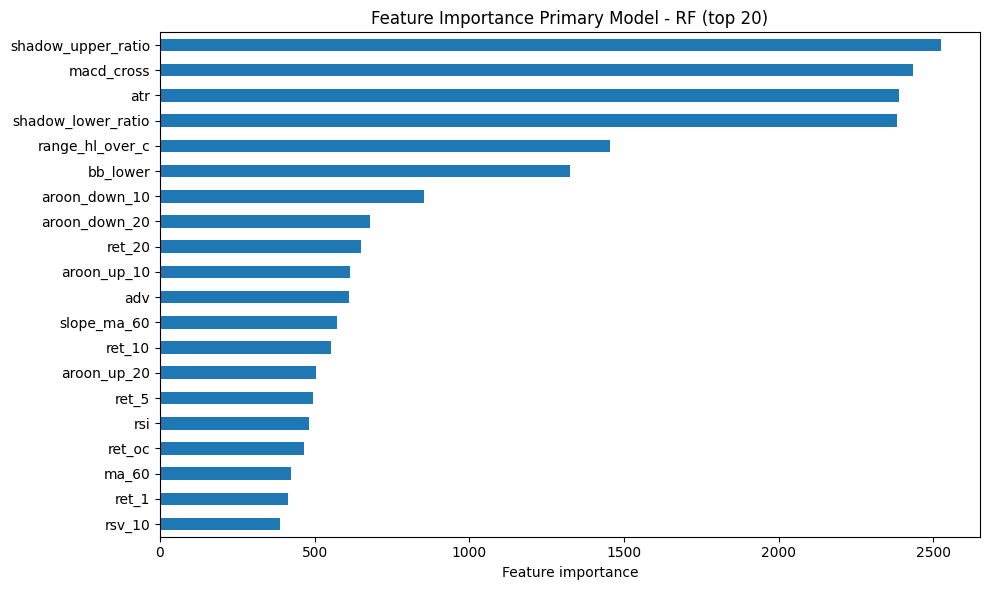

In [186]:
importances = primary_full.feature_importances_
feat_imp = pd.Series(importances, index=X_train_full_primary.columns).sort_values(ascending=False)
feat_imp_20 = feat_imp.head(20)

plt.figure(figsize=(10, 6))
feat_imp_20[::-1].plot(kind="barh")  # reverse to get largest at top
plt.xlabel("Feature importance")
plt.title(f"Feature Importance Primary Model - RF (top {20})")
plt.tight_layout()
plt.show()

## Train Secondary Model

In [187]:
permno_list = X_TRAIN["PERMNO"].unique()

In [188]:
data_indexed = X_TRAIN.set_index(["Date", "PERMNO"], drop=False)
data_indexed = data_indexed.sort_index(level=0)

In [189]:
from Labeling import meta_labeling
# Based on the Out of Sample Prediction for the Training Data obtained using pruged CV,
# label the event [1,0] if profitable or not.
data_meta_dict = {}

for id in permno_list:
    
    data_sub = data_indexed.xs(id, level="PERMNO").sort_index()
    prices_sub = prices.xs(id, level="PERMNO").sort_index()

    labels = meta_labeling(data_sub, prices_sub["DlyClose"], threshold=0.4)
    
    labeled_events = pd.merge(data_sub, labels, left_index=True, right_index=True)
    data_meta_dict[id] = labeled_events

In [190]:
X_TRAIN = pd.concat(data_meta_dict, ignore_index=True)

In [191]:
X_TRAIN.columns

Index(['Date', 'PERMNO', 'ma_5', 'ema_5', 'slope_ma_5', 'ma_10', 'ema_10',
       'slope_ma_10', 'ma_20', 'ema_20', 'slope_ma_20', 'ma_60', 'ema_60',
       'slope_ma_60', 'ret_1', 'ret_5', 'ret_10', 'ret_20', 'macd_dif',
       'macd_dea', 'macd', 'macd_cross', 'bb_mid', 'bb_upper', 'bb_lower',
       'bb_pctB', 'rsi', 'rsv_10', 'rsv_20', 'aroon_up_10', 'aroon_down_10',
       'aroon_up_20', 'aroon_down_20', 'range_hl_over_c', 'atr', 'gap_oc_prev',
       'gap_cc_prev', 'shadow_upper_ratio', 'shadow_lower_ratio', 'ret_c2c',
       'ret_co', 'ret_oc', 'vol', 'adv', 'dvol', 'vol_z', 'turnover_proxy',
       'vwap_proxy', 'pv_corr', 'pv_divergence', 'label', 'DlyClose',
       'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side',
       'pred_Side', 'pred_Side_proba', 'Return of Label', 'Label'],
      dtype='object')

In [192]:
X_TRAIN["Label"].value_counts()

Label
0.0    194585
1.0     48812
Name: count, dtype: int64

In [193]:
#include predicted Side and Probabilities in Meta Model
Drop = Label_cols + ["Date", "Return of Label", "Label"]
X_meta = X_TRAIN.drop(columns=Drop)

Y_meta = X_TRAIN["Label"].values

In [194]:
# Fit the model using Lightgbm.
secondary = lgbm.LGBMClassifier(
                    objective='multiclass',
                    num_class=3,
                    max_depth = 5,
                    n_estimators = 300, 
                    learning_rate = 0.05,
                    #num_leaves=32,
                    random_state=42,
                    )

#fit model using early stopping.
secondary.fit(X_meta,
            Y_meta,
            eval_metric='multi_logloss',
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12498
[LightGBM] [Info] Number of data points in the train set: 243397, number of used features: 50
[LightGBM] [Info] Start training from score -0.223825
[LightGBM] [Info] Start training from score -1.606718
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# 3. Prediction on Held Out Test Set

In [195]:
X_TEST.columns

Index(['Date', 'PERMNO', 'ma_5', 'ema_5', 'slope_ma_5', 'ma_10', 'ema_10',
       'slope_ma_10', 'ma_20', 'ema_20', 'slope_ma_20', 'ma_60', 'ema_60',
       'slope_ma_60', 'ret_1', 'ret_5', 'ret_10', 'ret_20', 'macd_dif',
       'macd_dea', 'macd', 'macd_cross', 'bb_mid', 'bb_upper', 'bb_lower',
       'bb_pctB', 'rsi', 'rsv_10', 'rsv_20', 'aroon_up_10', 'aroon_down_10',
       'aroon_up_20', 'aroon_down_20', 'range_hl_over_c', 'atr', 'gap_oc_prev',
       'gap_cc_prev', 'shadow_upper_ratio', 'shadow_lower_ratio', 'ret_c2c',
       'ret_co', 'ret_oc', 'vol', 'adv', 'dvol', 'vol_z', 'turnover_proxy',
       'vwap_proxy', 'pv_corr', 'pv_divergence', 'label', 'DlyClose',
       'timestamp', 'End Time', 'Return', 'trade_days', 'Return_dly', 'Side'],
      dtype='object')

In [196]:
Drop = Label_cols + ["Date"]

X_test = X_TEST.drop(columns=Drop)
Y_train = X_TEST["Side"].values

In [197]:
# Primary predictions on held-out test
side_proba= primary_full.predict_proba(X_test)
side_pred = primary_full.predict(X_test)

In [198]:
X_test.loc[: , "pred_Side"] = side_pred
X_test.loc[: , "pred_Side_proba"] = np.max(side_proba, axis=1)

X_TEST.loc[: , "pred_Side"] = side_pred
X_TEST.loc[: , "pred_Side_proba"] = np.max(side_proba, axis=1)

In [199]:
label = secondary.predict(X_test)
label_prob = np.max(secondary.predict_proba(X_test) , axis = 1) 

In [200]:
X_TEST.loc[: , "pred_Label"] = label
X_TEST.loc[: , "pred_Label_proba"] = label_prob
X_TEST

,Date,PERMNO,ma_5,ema_5,slope_ma_5,ma_10,ema_10,slope_ma_10,ma_20,ema_20,...,timestamp,End Time,Return,trade_days,Return_dly,Side,pred_Side,pred_Side_proba,pred_Label,pred_Label_proba
258249,2017-04-03,47706,-0.670532,-0.670713,-0.444523,-0.667281,-0.667210,-0.205004,-0.660553,-0.661725,...,2017-04-03,2017-04-11,0.023100,7,0.003300,1.0,0.0,0.441021,0.0,0.993803
258250,2017-04-03,46463,-0.461272,-0.460957,-0.444523,-0.459908,-0.459778,-0.231990,-0.459220,-0.457454,...,2017-04-03,2017-04-07,-0.016878,5,-0.003376,0.0,1.0,0.438860,1.0,0.522831
258251,2017-04-03,18075,-0.658206,-0.661167,-0.139734,-0.657689,-0.658546,-0.097061,-0.656386,-0.655895,...,2017-04-03,2017-04-05,-0.043165,3,-0.014388,-1.0,1.0,0.457712,1.0,0.532667
258252,2017-04-03,90902,-0.338616,-0.331254,1.536608,-0.344376,-0.341332,1.414150,-0.353691,-0.352049,...,2017-04-03,2017-04-04,-0.015748,2,-0.007874,0.0,1.0,0.400445,0.0,0.611659
258253,2017-04-03,12447,-0.782911,-0.781340,-0.017818,-0.781043,-0.781549,0.437260,-0.782310,-0.779761,...,2017-04-03,2017-04-06,0.036861,4,0.009215,1.0,-1.0,0.558471,1.0,0.542381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432907,2019-12-31,93339,-0.701954,-0.699344,0.501358,-0.700008,-0.698811,-0.133233,-0.692517,-0.702174,...,2019-12-31,2020-01-07,-0.119103,5,-0.023821,-1.0,-1.0,0.667605,1.0,0.516248
432908,2019-12-31,13429,-0.518101,-0.517093,0.405549,-0.516726,-0.516089,-0.241109,-0.512512,-0.511296,...,2019-12-31,2020-01-02,-0.018607,2,-0.009303,0.0,0.0,0.468403,0.0,0.999226
432909,2019-12-31,69761,-0.670030,-0.669286,0.204349,-0.668965,-0.669359,-0.525510,-0.669657,-0.669938,...,2019-12-31,2020-01-02,0.025210,2,0.012605,1.0,-1.0,0.524067,0.0,0.697955
432910,2019-12-31,85604,0.143098,0.144323,0.875015,0.140216,0.143409,0.822942,0.145994,0.151934,...,2019-12-31,2020-01-02,-0.024066,2,-0.012033,-1.0,0.0,0.467919,0.0,0.999093


In [201]:
X_TEST["pred_Side"].value_counts()

pred_Side
 0.0    94195
 1.0    43130
-1.0    37338
Name: count, dtype: int64

In [202]:
with open('./Data/scores_test_side_meta_labeled_lgbm.pkl', 'wb') as file:
    pkl.dump(X_TEST, file)

# Backtesting the Strategy


We now have all predictions on the Test set
Recap: Meta_Label is set based on a minimal profit of 2% at event endtime, so model should try to learn/focus on events with actual return.

Test the following Strategy: 
- Leverage the Label Probability to determine Trades to take and compute return of that strategy.

In [203]:
with open('./Data/scores_test_side_meta_labeled_lgbm.pkl', 'rb') as file:
    X_backtest = pkl.load(file)

In [204]:
def return_of_Label(
    events: pd.DataFrame,
    Label_prob = 0.7,
) -> pd.DataFrame:

    events_filtered = events.dropna(subset=['End Time'])
    out = pd.DataFrame(index=events_filtered.index)

    out["Date"] = events_filtered["Date"]

    #Return of Label = positive if sign of return equal predicted Side and vice versa
    out['Return of Label'] = events_filtered["Return"] * events_filtered['pred_Side']

    #return of each event
    out["event_ret"] = out['Return of Label'] * events_filtered['pred_Label']

    #If Probability to Trade less then threshold set value to zero --> No Trade
    out.loc[(events_filtered["pred_Label_proba"] <= Label_prob), "event_ret"] = 0
    
    out["event_ret_dly"] = out["event_ret"] / events_filtered["trade_days"]

    return out

In [205]:
df_results = return_of_Label(X_backtest)

In [206]:
df_results

,Date,Return of Label,event_ret,event_ret_dly
258249,2017-04-03,0.000000,0.0,0.0
258250,2017-04-03,-0.016878,0.0,0.0
258251,2017-04-03,-0.043165,0.0,0.0
258252,2017-04-03,-0.015748,0.0,0.0
258253,2017-04-03,-0.036861,0.0,0.0
...,...,...,...,...
432907,2019-12-31,0.119103,0.0,0.0
432908,2019-12-31,-0.000000,-0.0,-0.0
432909,2019-12-31,-0.025210,0.0,0.0
432910,2019-12-31,-0.000000,-0.0,-0.0


In [207]:
# Basic stats
df_backtest = df_results[df_results["event_ret"] != 0]

In [209]:
daily_ret = (
    df_backtest
    .groupby("Date")["event_ret_dly"]
    .mean()
    .sort_index()
)

# 累计收益曲线（简单收益）
equity_curve = (1 + daily_ret).cumprod()

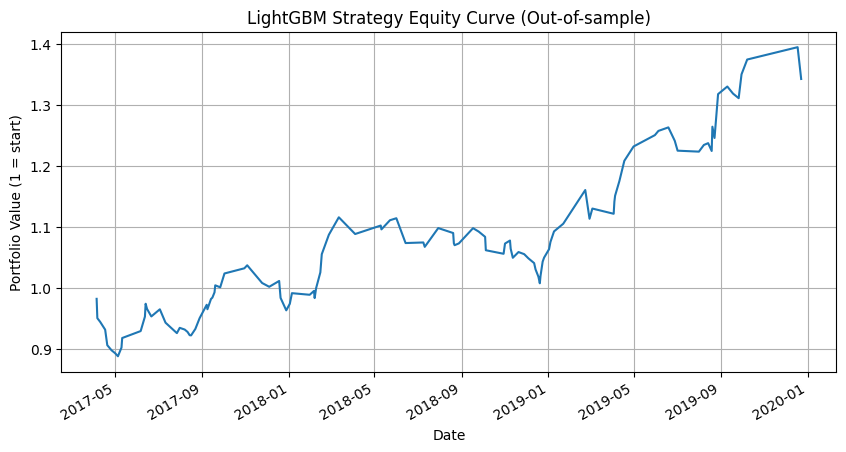

In [210]:
plt.figure(figsize=(10, 5))
equity_curve.plot()
plt.title("LightGBM Strategy Equity Curve (Out-of-sample)")
plt.ylabel("Portfolio Value (1 = start)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [211]:
mu_d = daily_ret.mean()
sigma_d = daily_ret.std()

# 每年交易天数
annual_factor = 252

annual_return = (1 + mu_d)**annual_factor - 1

In [218]:
mu_d    = daily_ret.mean()
sigma_d = daily_ret.std()

annual_factor = 252
# annualized volatility
annual_vol = sigma_d * np.sqrt(annual_factor)

# annualized Sharpe (no risk-free)
sharpe = mu_d / sigma_d * np.sqrt(annual_factor)

In [219]:
sharpe

np.float64(2.4616986280146014)

In [220]:
cum_curve = (1 + daily_ret).cumprod()
cum_max = cum_curve.cummax()
drawdown = cum_curve / cum_max - 1
max_dd = drawdown.min()
win_rate = (daily_ret > 0).mean()
T_years = (equity_curve.index[-1] - equity_curve.index[0]).days / 365.25
CAGR = equity_curve.iloc[-1]**(1 / T_years) - 1

In [221]:
perf = pd.Series({
    "Return": CAGR,
    "Annual Vol": annual_vol,
    "Sharpe": sharpe,
    "Max Drawdown": max_dd,
    "Win Rate (daily)": win_rate,
})
print(perf)

#In the 2017 out-of-sample backtesting, the prediction strategy based on LightGBM achieved an annualized return of approximately 6%,
#with an annualized volatility of only about 5.3%, a maximum drawdown of about 3.3%, an annualized Sharpe ratio of 1.13, and a daily 
#win rate of approximately 52.6%. This indicates that the model does possess a certain predictive ability in directional judgment and 
#can obtain moderate positive returns at a relatively low risk level. However, the overall alpha is limited.

Return              0.114574
Annual Vol          0.280701
Sharpe              2.461699
Max Drawdown       -0.096950
Win Rate (daily)    0.535088
dtype: float64


In [ ]:
#Comparison
#The Random Forest model achieved a label prediction accuracy of approximately 54.4%, slightly higher than the LightGBM model 
#(approximately 52.4%). However, at the strategy level, the two differed significantly: the LightGBM strategy achieved an annualized 
#return of approximately 5.97% and an annualized volatility of 5.26% during the backtesting period, corresponding to an annualized
#Sharpe ratio of 1.13 and a maximum drawdown of approximately 3.3%; while the Random Forest strategy had an annualized Sharpe of only 
#approximately 0.38. This indicates that although Random Forest has a slight advantage in classification accuracy, its profit and loss
#distribution is worse, and the losses from mispredictions are greater, making it difficult to translate into attractive risk-adjusted 
#returns.

#Considering both label accuracy and strategy performance, the LightGBM model significantly outperforms Random Forest under the settings 
#of this study and is more suitable as the main model for subsequent strategy optimization and expansion, while Random Forest is more 
#suitable as a control or ensemble component.